В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import pandas as pd
import numpy as np

from mlpeople.io.google_drive import download_file_iss

# download files from google drive
download_file_iss('1Xz-cqp6y-Y_oCiaSJeNsbU3-o5lM-5wY', output_path='./downloads/train.csv')
download_file_iss('1jsg2iPVphDMiHCEyqQeDSc4yDcMB3-r_', output_path='./downloads/test.csv')
download_file_iss('1tv0beG2n8cUQ6KcdaXhFzQI_Fd9640gg', output_path='./downloads/sample_submission.csv')

# read train.csv / show first 5 rows / show info
raw_df = pd.read_csv('downloads/train.csv')
display(raw_df.shape)
display(raw_df.head())
display(raw_df.info())

(15000, 14)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


None

In [2]:
from mlpeople.eda.reporting import describe_dataframe

describe_dataframe(raw_df)

,column_id,data_type,unique_values,missing_values,mean,std,min,max
0,id,int64,15000,0,7499.50,4330.27,0.00,14999.00
1,CustomerId,float64,6348,0,15691456.68,135205.03,1581102.00,15815690.00
2,Surname,object,764,0,NaN,NaN,NaN,NaN
3,CreditScore,float64,378,0,658.94,72.26,431.00,850.00
4,Geography,object,3,0,NaN,NaN,NaN,NaN
5,Gender,object,2,0,NaN,NaN,NaN,NaN
6,Age,float64,56,0,37.74,8.22,18.00,74.00
7,Tenure,float64,11,0,5.03,2.78,0.00,10.00
8,Balance,float64,3395,0,42729.79,59727.31,0.00,209767.31
9,NumOfProducts,float64,4,0,1.59,0.53,1.00,4.00


In [3]:
raw_df["Exited"].value_counts(normalize=True)

Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64

In [4]:
# split train and test data
from sklearn.model_selection import train_test_split

def split_train_val(df, test_size=0.2, random_state=42, stratif_by_col=None):
    if stratif_by_col is not None:
        return train_test_split(raw_df, test_size=test_size, random_state=random_state, stratify=df[stratif_by_col])
    else:
        return train_test_split(raw_df, test_size=test_size, random_state=random_state)

train_df, val_df = split_train_val(raw_df, test_size=0.2, random_state=42, stratif_by_col="Exited")

train_df["Exited"].value_counts(normalize=True)


Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64

<span style="background-color: #f60">Відповідь:</span><br/>
 - У наборі даних близько 80% цільових значень дорівнюють 0 (співвідношення 4:1). Водночас набір даних є достатньо великим, тому при випадковому розбитті на тренувальний і валідаційний набори це співвідношення, як правило, зберігається в обох вибірках навіть без використання параметра stratify.
 - Використання параметра stratify із цільовою колонкою дозволяє забезпечити майже ідентичну пропорцію класів у тренувальному та валідаційному наборах - з точністю до сотих часток.

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [5]:
target_col = "Exited"
drop_from_input_cols = [target_col, "id", "CustomerId", "Surname"] # surname seems to be useless here
input_cols = raw_df.columns.drop(drop_from_input_cols)

print(f"target col: {target_col}")
print(f"input cols: {input_cols}")

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

target col: Exited
input cols: Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [6]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(f"numeric_cols: {numeric_cols}")
print(f"categorical_cols: {categorical_cols}")

numeric_cols: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
categorical_cols: ['Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

# there is no missing values in train data, but create imputer in case of missing values in test data
# use SimpleImputer strategy="mean" for base model version
def get_fitted_imputer(train_inputs, cols=None, strategy="mean"):
    if cols is None:
        cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(train_inputs[cols])

    return imputer

# scale numeric values
# ability to experiment with mode ("MinMax" or "Standard")
def get_fitted_scaler(train_inputs, cols=None, mode="minmax"):
    if cols is None:
        cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

    if mode == "minmax":
        scaler = MinMaxScaler()
    elif mode == "standard":
        scaler = StandardScaler()
    else:
        raise ValueError('mode param expected to be "minmax" or "standard"')

    scaler.fit(train_inputs[cols])

    return scaler

# one hot encoder for categorical columns
# drop if binary by default for 'Gender' col
def get_fitted_one_hot_encoder(
    train_inputs,
    cols=None,
    sparse_output=False,
    handle_unknown="ignore",
    drop="if_binary"
):
    if cols is None:
        cols = train_inputs.select_dtypes(include="object").columns.tolist()
        
    encoder = OneHotEncoder(
        sparse_output=sparse_output,
        handle_unknown=handle_unknown,
        drop=drop
    )

    encoder.fit(train_inputs[cols])

    return encoder


In [9]:
# impute
imputer = get_fitted_imputer(train_inputs, cols=numeric_cols)
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])

# scale
scaler = get_fitted_scaler(train_inputs, cols=numeric_cols, mode="minmax")
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

# one hot encode
encoder = get_fitted_one_hot_encoder(train_inputs, cols=categorical_cols)
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [10]:
display(train_inputs.head(5))
display(val_inputs.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,1.0
10393,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,0.0
80,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,1.0
3365,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,1.0
12236,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
6490,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,1.0
3646,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,1.0
5306,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,0.0
652,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,0.0
2627,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,0.0


<span style="background-color: #f60">Відповідь:</span><br/>
 - Категоріальну колонку Surname було відкинуто ще на попередньому етапі, оскільки вона, схоже, не містить корисної інформації для моделі.
 - Для двох інших категоріальних колонок Gender та Geography використали OneHotEncoder. Оскільки Gender має лише два значення, доцільно залишити тільки одну колонку з 0 та 1 (параметр drop="if_binary").
 - У тренувальному наборі даних відсутні пропущені значення серед усіх числових колонок. Проте, щоб уникнути потенційних проблем при роботі з тестовими або реальними даними, було створено екземпляр SimpleImputer із параметром strategy="mean", який натренували на тренувальному наборі.
 - Для першої моделі числові значення маштабували за допомогою MinMaxScaler. Цей крок здається необхідним, оскільки деякі колонки у початковому наборі мають значення на порядок більші за інші.

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [17]:
from pathlib import Path
import os

data_dir = Path("data/bank-customer")
data_dir.mkdir(parents=True, exist_ok=True)

train_inputs.to_parquet(data_dir / "train_inputs.parquet")
val_inputs.to_parquet(data_dir / "val_inputs.parquet")

pd.DataFrame(train_targets).to_parquet(data_dir / "train_targets.parquet")
pd.DataFrame(val_targets).to_parquet(data_dir / "val_targets.parquet")

os.listdir(data_dir)

['train_targets.parquet',
 'train_inputs.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [18]:
from sklearn.linear_model import LogisticRegression

X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Training F1 score: 63.52%


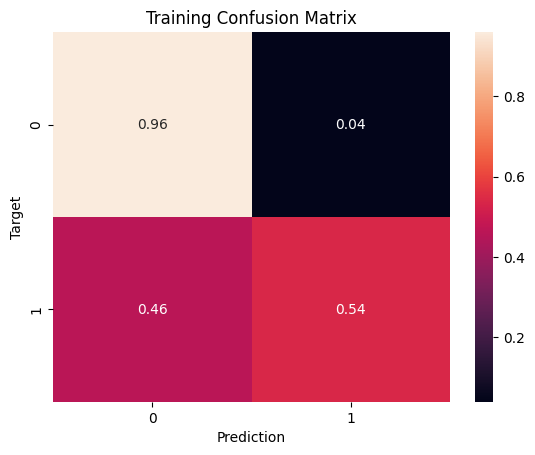

AUROC for Training: 0.88


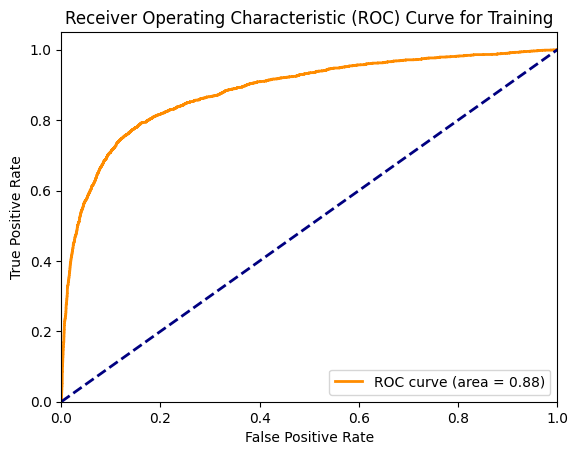

Validation F1 score: 64.12%


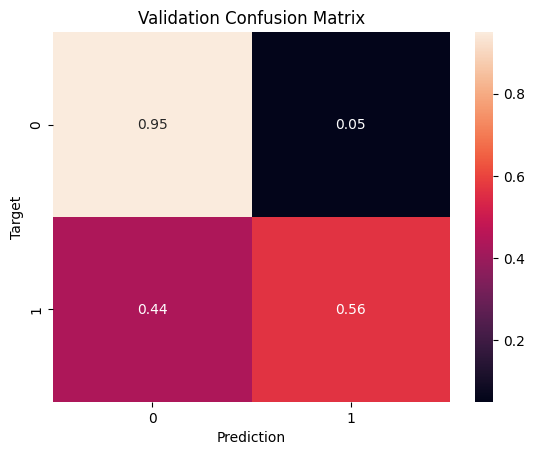

AUROC for Validation: 0.88


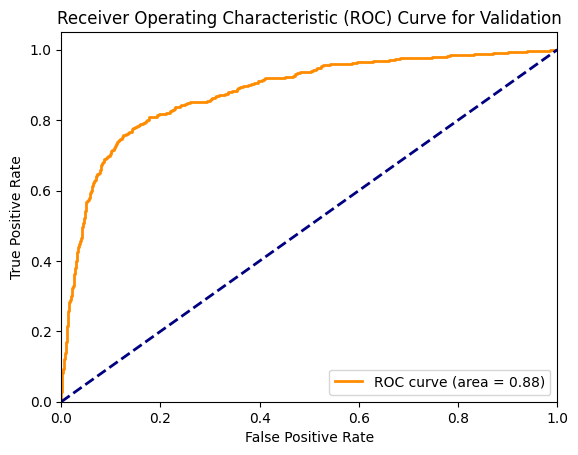

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def predict_and_plot(inputs, targets, name='', threshold=0.5):
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # predict target based on threshold, calculate f1 and confusion matrix
    preds = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(targets, preds, pos_label=1)
    print(name + " F1 score: {:.2f}%".format(f1 * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    return preds, y_pred_proba

train_preds, train_pred_proba = predict_and_plot(X_train, train_targets, 'Training')
val_preds, val_pred_proba = predict_and_plot(X_val, val_targets, 'Validation')

<span style="background-color: #f60">Відповідь:</span><br/>
 - Судячи з показників, модель працює досить непогано. F1-score перевищує 0.63, а ROC-крива виглядає адекватно та добре.
 - Також варто зауважити, що точність моделі на валідаційних даних виявилася навіть дещо вищою, ніж на тренувальних.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [ ]:
from sklearn.metrics import accuracy_score

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

print(f"Train acc: {accuracy_score(train_targets, train_preds)}")
print(f"Val acc: {accuracy_score(val_targets, val_preds)}")

most_freq_target = train_targets.mode()
train_dumb_preds = np.repeat(most_freq_target, X_train.shape[0])
val_dumb_preds = np.repeat(most_freq_target, X_val.shape[0])

print(f"Train dumb acc: {accuracy_score(train_targets, train_dumb_preds)}")
print(f"Val dumb acc: {accuracy_score(val_targets, val_dumb_preds)}")

Train acc: 0.87425
Val acc: 0.8716666666666667
Train dumb acc: 0.7965
Val dumb acc: 0.7966666666666666


<span style="background-color: #f60">Відповідь:</span><br/>
 - Accuracy для моделі, яка завжди передбачає мажоритарний клас, дорівнює відсотку значень мажоритарного класу у початкових даних і становить приблизно 0.8.
 - Для натренованої моделі Accuracy перевищує 0.87 як на тренувальних, так і на валідаційних даних.
 - Судячи з результатів цього та попереднього кроків, можна зробити висновок, що якість нашої моделі як мінімум задовільна.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [39]:
from pathlib import Path
import joblib

# Ensure the directory exists
model_dir = Path("models")
model_dir.mkdir(parents=True, exist_ok=True)

# Save your dictionary safely
log_reg = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(log_reg, model_dir / "log_reg.joblib")


['models/log_reg.joblib']

In [41]:
model_2 = joblib.load("models/log_reg.joblib")
val_preds2 = model_2['model'].predict(X_val)
accuracy_score(val_targets, val_preds2)

0.8716666666666667

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [42]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(imputer, scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [43]:
predict_raw_df(imputer, scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

array([0.00653297, 0.03674711, 0.37092276, 0.37605273, 0.97579676])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [57]:
test_raw_df = pd.read_csv("downloads/test.csv")

pred_test_probs = predict_raw_df(imputer, scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

test_raw_df["Exited"] = pred_test_probs.round(4) # (pred_test_probs >= 0.5).astype(int)
test_raw_df["Exited"].head()

0    0.0753
1    0.0354
2    0.1530
3    0.1947
4    0.0556
Name: Exited, dtype: float64

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [58]:
sample_submission_df = pd.read_csv("downloads/sample_submission.csv")

sample_submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [59]:
sample_submission_df["Exited"] = test_raw_df["Exited"]
sample_submission_df.head()

,id,Exited
0,15000,0.0753
1,15001,0.0354
2,15002,0.1530
3,15003,0.1947
4,15004,0.0556


In [60]:
sample_submission_df.to_csv("data/submission_log_reg.csv", index=False)